# Feature selection for multi-variate LR model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("AmesHousing.txt", delimiter="\t")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [3]:
#lets divide the dataset into training and testing datasets
train = data.iloc[0:1460]
test = data.iloc[1460:]
#keep columns with numeriacal attributes
numerical_train = train.select_dtypes(include=['int', 'float'])
numerical_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
Order              1460 non-null int64
PID                1460 non-null int64
MS SubClass        1460 non-null int64
Lot Frontage       1211 non-null float64
Lot Area           1460 non-null int64
Overall Qual       1460 non-null int64
Overall Cond       1460 non-null int64
Year Built         1460 non-null int64
Year Remod/Add     1460 non-null int64
Mas Vnr Area       1449 non-null float64
BsmtFin SF 1       1459 non-null float64
BsmtFin SF 2       1459 non-null float64
Bsmt Unf SF        1459 non-null float64
Total Bsmt SF      1459 non-null float64
1st Flr SF         1460 non-null int64
2nd Flr SF         1460 non-null int64
Low Qual Fin SF    1460 non-null int64
Gr Liv Area        1460 non-null int64
Bsmt Full Bath     1459 non-null float64
Bsmt Half Bath     1459 non-null float64
Full Bath          1460 non-null int64
Half Bath          1460 non-null int64
Bedroom AbvGr      

In [4]:
# By analyzing the dataset info from above we'll  focus on selecting columns
#that don't have any missing values or don't need to be transformed to be useful 
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold',\
                                        'Yr Sold'], axis=1)
#calculate missing values in numerical_train

null_series = numerical_train.isnull().sum()

#remove nan elements

full_cols_series = null_series[null_series == 0]
full_cols_series

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

In [5]:
#calculting correlation coefficients
train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
#select correlatio coefficients w.r.t sales Price
sorted_cors = corrmat['SalePrice'].abs().sort_values()
sorted_cors

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64

In [6]:
# select columns with columns greater than 0.3
strong_cors = sorted_cors[sorted_cors > 0.3]

#we need to look for potential colinearity between the left columns as we might not wqnt to keep columns which are
#very similar to each other
import seaborn as sns
import matplotlib.pyplot as plt


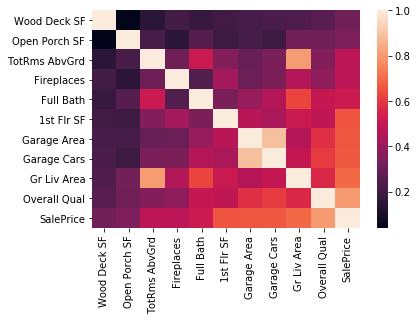

In [7]:
%matplotlib inline
corrmat = train_subset[strong_cors.index].corr()
sns.heatmap(corrmat)

In [8]:
#from the graph we can see that 1)Gr Liv Area and TotRms AbvGrd 2)Garage Area and Garage Cars are strongly correlated
#so we drop TotRms AbvGrd and Garage Cars columns
final_corr_cols = strong_cors.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'
clean_test = test[final_corr_cols.index].dropna()

In [9]:
#buiding a LR model and calculate RMSE
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

34173.9762919
41032.0261202


In [10]:
# we can further improve our model by removing features with low variances
# First we rescale
unit_train = (train[features] - train[features].min())/(train[features].max() - train[features].min())
print(unit_train.min())
print(unit_train.max())
# Confirmed: the min and max values are 0.0 and 1.0 respectively
sorted_vars = unit_train.var().sort_values()
print(sorted_vars)

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64
Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


In [11]:
# lets cut-ff variance at 0.015. Now we'll have to remove Open Porch SF
clean_test = test[final_corr_cols.index].dropna()
features = features.drop('Open Porch SF')

lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse_2 = np.sqrt(train_mse)
test_rmse_2 = np.sqrt(test_mse)

print(train_rmse_2)
print(test_rmse_2)

34372.6967078
40591.4270244


In [ ]:
# we can observe that the RMSE value has decreased when compared to the earlier model.